<a href="https://colab.research.google.com/github/ies9357/AIB_CP1_project/blob/main/Section6_CP1_EfficientNetB1_v1_%EB%AA%A8%EB%8D%B8_%EB%A1%9C%EB%94%A9_%ED%9B%84_%EC%8B%A4%ED%96%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1.데이터 전처리

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

np.random.seed(42)
tf.random.set_seed(42)

(450, 600, 3)


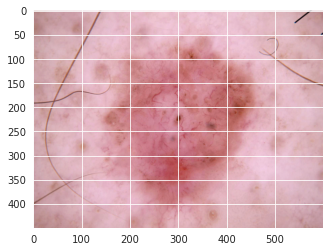

In [ ]:
# 1장의 이미지(기저세포암종 - BCC) 확인

image_path=r'/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터/BCC(기저 세포 암종)/ISIC_0024332.jpg'
img=plt.imread(image_path)
print(img.shape)
imshow(img);

(300, 300, 3)


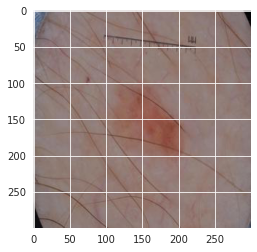

In [ ]:
image_path=r'/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터/malignant(흑색종 악성)/melanoma_10116.jpg'
img=plt.imread(image_path)
print(img.shape)
imshow(img);

##1]. 피부암 이미지의 데이터프레임 구축

In [ ]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터'
class_list = os.listdir(images_dir)
class_list

['benign(흑색종 양성)',
 'malignant(흑색종 악성)',
 'nevus(모반)',
 'seborrheic_keratosis(지루성 각화증)',
 'BCC(기저 세포 암종)']

In [ ]:
# 파일경로와 라벨에 대한 데이터 프레임 만들기

images_dir = '/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터'
class_list = os.listdir(images_dir) # ['benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)', 'BCC(기저 세포 암종)'] << os.listdir(images_dir)

file_pathes = []
labels = []

# file이름의 list들을 file_paths에 저장
for cls in class_list:
  class_path = os.path.join(images_dir, cls) # 하나의 클래스 폴더[ex. 'benign(흑색종 양성)', 'malignant(흑색종 악성)']의 경로
  file_list = os.listdir(class_path) # 폴더(class_path) 내 모든 파일리스트 출력

  for f in file_list:
    file_path = os.path.join(class_path, f) # 클래스 폴더의 경로에 파일 이름을 붙혀 파일경로 생성
    file_pathes.append(file_path) # 파일경로를 하나하나씩 붙여 파일경로 리스트 생성
    labels.append(cls) # 파일 경로 하나하나에 대한 라벨들을 labels라는 리스트에 붙힘

file_series = pd.Series(file_pathes, name = 'file_pathes')
label_series = pd.Series(labels, name = 'labels')
df = pd.concat([file_series, label_series], axis = 1)

##2]. 데이터프레임 전처리

In [ ]:
# 데이터프레임 전처리 & 분할


train_df, dummy_df = train_test_split(df, train_size = 0.9, shuffle = True,
                                      random_state = 123)
valid_df, test_df=train_test_split(dummy_df, train_size = 0.5,
                                   shuffle = True, random_state = 123)
print('train_df의 크기 : {}\ntest_df의 크기 : {}\nvalid_df[validation dataframe]의 크기 : {}'.format(len(train_df), len(test_df), len(valid_df)))

train_labels_count = train_df['labels'].value_counts()
train_labels_count_norm = round(train_df['labels'].value_counts(normalize = True) * 100, 2)
# for b in balance:
#     print (b)


train_df의 크기 : 18065
test_df의 크기 : 1004
valid_df[validation dataframe]의 크기 : 1004


In [ ]:
# 불균형 데이터로 인한 학습문제를 해결하기 위해 oversampling 후 일부 데이터셋 빼고 진행

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state = 42) # ros : random over sampler(랜덤 오버샘플러)
file_pathes_over, labels_over = ros.fit_resample(pd.DataFrame(train_df['file_pathes']), pd.DataFrame(train_df['labels']))
train_df_over = pd.concat([file_pathes_over, labels_over], axis = 1).sample(6000, replace = False, weights = None,
                             random_state = 123,
                             axis = 0).reset_index(drop = True)
train_df_over

,file_pathes,labels
0,/content/drive/MyDrive/Colab Notebooks/Section...,malignant(흑색종 악성)
1,/content/drive/MyDrive/Colab Notebooks/Section...,nevus(모반)
2,/content/drive/MyDrive/Colab Notebooks/Section...,malignant(흑색종 악성)
3,/content/drive/MyDrive/Colab Notebooks/Section...,seborrheic_keratosis(지루성 각화증)
4,/content/drive/MyDrive/Colab Notebooks/Section...,seborrheic_keratosis(지루성 각화증)
...,...,...
5995,/content/drive/MyDrive/Colab Notebooks/Section...,malignant(흑색종 악성)
5996,/content/drive/MyDrive/Colab Notebooks/Section...,benign(흑색종 양성)
5997,/content/drive/MyDrive/Colab Notebooks/Section...,malignant(흑색종 악성)
5998,/content/drive/MyDrive/Colab Notebooks/Section...,seborrheic_keratosis(지루성 각화증)


In [ ]:
# 이미지 전처리 사이즈 설정

height = 256
width = 256
channels = 3
batch_size = 40
img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df) # 1004

In [ ]:
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) \
                          if length % n == 0 and length / n <= 80], \
                         reverse = True)[0]  
test_steps = int(length/test_batch_size)
print('test셋의 batch size : {}\ntest셋의 steps: \
{}'.format(test_batch_size, test_steps))


test셋의 batch size : 4
test셋의 steps: 251


##3]. 이미지 전처리

In [ ]:
# ImageDataGenerator를 통한 데이터 증강, 데이터 파이프라인 구축

# 참고 :  : https://techblog-history-younghunjo1.tistory.com/252?category=922523

def scalar(img):
  # img = img / 127.5 - 1
  return img

trgen = ImageDataGenerator(preprocessing_function = scalar,
                           horizontal_flip = True)
tvgen = ImageDataGenerator(preprocessing_function = scalar)

train_gen = trgen.flow_from_dataframe(train_df_over, x_col = 'file_pathes',
                                      y_col = 'labels',
                                      target_size = img_size,
                                      class_mode = 'categorical',
                                      color_mode = 'rgb', shuffle = True,
                                      batch_size = batch_size)

test_gen = tvgen.flow_from_dataframe(test_df, x_col = 'file_pathes',
                                     y_col = 'labels',
                                     target_size = img_size,
                                     class_mode = 'categorical',
                                     color_mode = 'rgb', shuffle = False,
                                     batch_size = test_batch_size)

valid_gen = tvgen.flow_from_dataframe(valid_df, x_col = 'file_pathes',
                                      y_col = 'labels',
                                      target_size = img_size,
                                      class_mode = 'categorical',
                                      color_mode = 'rgb', shuffle = True,
                                      batch_size = batch_size)


Found 6000 validated image filenames belonging to 5 classes.
Found 1004 validated image filenames belonging to 5 classes.
Found 1004 validated image filenames belonging to 5 classes.


In [ ]:
dic = {'BCC(기저 세포 암종)': 0,
    'benign(흑색종 양성)': 1,
    'malignant(흑색종 악성)': 2,
    'nevus(모반)': 3,
    'seborrheic_keratosis(지루성 각화증)': 4}

dic

{'BCC(기저 세포 암종)': 0,
 'benign(흑색종 양성)': 1,
 'malignant(흑색종 악성)': 2,
 'nevus(모반)': 3,
 'seborrheic_keratosis(지루성 각화증)': 4}

In [ ]:
train_gen.class_indices

{'BCC(기저 세포 암종)': 0,
 'benign(흑색종 양성)': 1,
 'malignant(흑색종 악성)': 2,
 'nevus(모반)': 3,
 'seborrheic_keratosis(지루성 각화증)': 4}

In [ ]:
classes = list(train_gen.class_indices.keys()) # ['BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)']
class_count = len(classes) # 5
train_steps = int(len(train_gen.labels) / batch_size) # 451 / len(train_gen.labels) = 18065


#2.모델학습

##1]. 학습한 모델 불러오기

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/EfficientNetB1-skin-cancer-93.52.h5')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
# 테스트 셋에 대한 예측 및 학습된 딥러닝모델의 이미지 분류 소요시간 & confusion matrix와 classification report 생성
import time

print_code=0

start = time.time()

preds=model.predict(test_gen)

print('학습된 EfficientNetB1 기반 딥러닝 모델이 {}장의 이미지 분류하는 데 걸리는 시간 : {}초'\
      .format(len(test_gen) * test_batch_size, time.time() - start))


# 학습된 EfficientNetB1 기반 딥러닝 모델이 1004장의 이미지 분류하는 데 걸리는 시간 : 약 27.15초
# 1장 당 분류시간 : 약 0.027초

학습된 EfficientNetB1 기반 딥러닝 모델이 1004장의 이미지 분류하는 데 걸리는 시간 : 27.154823064804077


In [ ]:
# 모델 학습 시, 모델학습과정을 볼 수 있는 텍스트에 대하여
# RGB 전경색 및 배경색으로 꾸며주는 함수를 정의한다.

def print_in_color(txt_msg, fore_tupple, back_tupple,):
    # back_tupple에서 지정한 배경과 함께 fore_tupple에서 지정한 전경색으로 text_msg를 인쇄합니다.
    # text_msg는 텍스트, fore_tupple은 전경색 튜플(r,g,b), back_tupple은 배경 튜플(r,g,b)을 뜻한다.

    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg.format(mat), flush = True)
    print('\33[0m', flush=True) # 기본 인쇄 색상을 검정색으로 되돌린다.
    return

In [ ]:
# confusion matrix와 classification report를 만들기 위한 함수 정의

def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

    return y_true, y_pred

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s

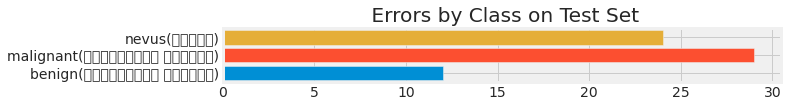

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4535 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4357 missing from current font.
  font.set_text(s

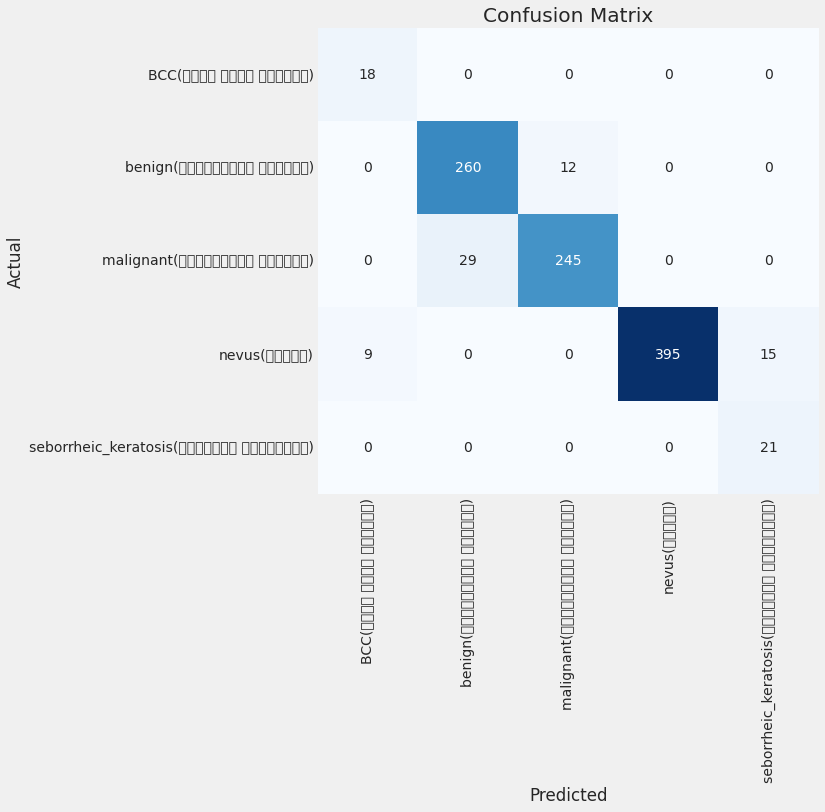

Classification Report:
----------------------
                                         precision    recall  f1-score   support

                 BCC(기저 세포 암종)       0.67      1.00      0.80        18
              benign(흑색종 양성)       0.90      0.96      0.93       272
           malignant(흑색종 악성)       0.95      0.89      0.92       274
                          nevus(모반)       1.00      0.94      0.97       419
seborrheic_keratosis(지루성 각화증)       0.58      1.00      0.74        21

                              accuracy                           0.94      1004
                             macro avg       0.82      0.96      0.87      1004
                          weighted avg       0.95      0.94      0.94      1004



In [ ]:
save_dir=r'/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project'
subject='skin-cancer'
y_true, y_pred = print_info(test_gen, preds, print_code, save_dir, subject)

In [ ]:
pred_true = 0
pred_false = 0
index_false = []

for i in range(len(y_true)):
  if y_true[i] == y_pred[i]:
    pred_true = pred_true + 1
  else:
    pred_false = pred_false + 1
    index_false.append(i)

print('정확도 : {}%'.format(100 * round(pred_true / (pred_true + pred_false), 4)))
print('예측이 틀린 경우의 이미지 인덱스 리스트[test_df 기준] : \n{}'.format(index_false))

정확도 : 93.53%
예측이 틀린 경우의 이미지 인덱스 리스트[test_df 기준] : 
[2, 14, 33, 63, 87, 92, 98, 112, 126, 132, 136, 188, 197, 207, 212, 244, 259, 270, 290, 321, 331, 338, 350, 360, 370, 374, 381, 413, 420, 442, 451, 463, 464, 467, 539, 541, 552, 562, 567, 572, 596, 645, 669, 681, 694, 714, 721, 730, 753, 760, 763, 771, 811, 838, 861, 881, 889, 900, 916, 917, 954, 968, 970, 972, 989]


In [ ]:
test_df['labels'].value_counts()

nevus(모반)                              419
malignant(흑색종 악성)               274
benign(흑색종 양성)                  272
seborrheic_keratosis(지루성 각화증)     21
BCC(기저 세포 암종)                      18
Name: labels, dtype: int64

In [ ]:
class_dict = test_gen.class_indices
class_dict_rev = {v:k for k, v in class_dict.items()}

In [ ]:
def 세포암진단(i):
  image_path = test_df['file_pathes'].iloc[i]
  img=plt.imread(image_path)
  print('실제 검사자 상태 : {}\n학습모델이 예측한 상태 : {}'.format(class_dict_rev[y_true[i]], class_dict_rev[y_pred[i]]))
  print('사진출처 : {}'.format(test_df['file_pathes'].iloc[i]))
  imshow(img);

실제 검사자 상태 : benign(흑색종 양성)
학습모델이 예측한 상태 : malignant(흑색종 악성)
사진출처 : /content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터/benign(흑색종 양성)/melanoma_4747.jpg


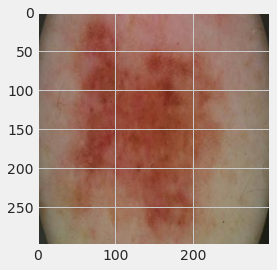

In [ ]:
세포암진단(132)

In [ ]:
# # Requirements.txt 제작

# !pip freeze > requirements.txt

In [ ]:
df['labels'].value_counts()

nevus(모반)                              8548
benign(흑색종 양성)                  5510
malignant(흑색종 악성)               5115
BCC(기저 세포 암종)                      514
seborrheic_keratosis(지루성 각화증)     386
Name: labels, dtype: int64

딥러닝 모델이 1장의 외부 이미지를 분류하는 데 
걸리는 시간 : 0.057초
딥러닝 모델의 예측 : malignant(흑색종 악성)


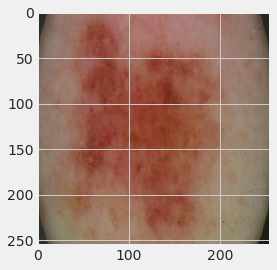

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.efficientnet import preprocess_input
import numpy as np

image_path=r'/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터/benign(흑색종 양성)/melanoma_4747.jpg'
image = load_img(image_path, target_size = (256, 256))
imshow(image)
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

start2 = time.time()
yhat = model.predict(image) # array([[0.9905043 , 0.002313  , 0.00249052, 0.00310126, 0.00159082]], dtype=float32)
print('딥러닝 모델이 1장의 외부 이미지를 분류하는 데 \n걸리는 시간 : {}초'.format(round(time.time() - start2, 3)))
dic = {0: 'BCC(기저 세포 암종)',
 1: 'benign(흑색종 양성)',
 2: 'malignant(흑색종 악성)',
 3: 'nevus(모반)',
 4: 'seborrheic_keratosis(지루성 각화증)'}

print('딥러닝 모델의 예측 : {}'.format(dic[np.argmax(yhat)]))

